# Snake

In [1]:
from environments import *
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import os
from models import *
import json
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
LOAD_FROM_MEMORY = True

## Environment definition

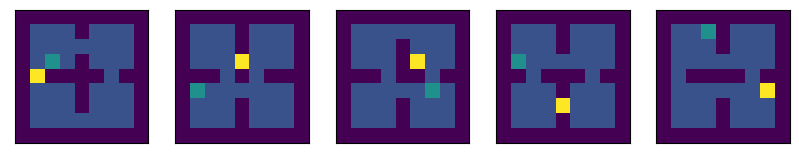

In [3]:
%matplotlib inline
def get_env(n=1000):
    e = Walls9x9SnakeEnvironment(n, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 25000
EPSILON = 0.03
LAMBDA_VALUE = 0.
LAMBDA_AGENT = 0.
#  ALPHA = 0.1

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Model

In [4]:
MODELS_PREFIX = f"models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}-{env_.mask_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [6]:
agent, value, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

loaded 1
loaded 2


## Training

In [36]:
avg_td_error = []

In [37]:
optimizer_value = tf.keras.optimizers.legacy.Adam(1e-4)
optimizer_agent = tf.keras.optimizers.legacy.Adam(1e-5)

In [38]:
eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]

In [39]:
%matplotlib inline
next_reset = 2
for iteration in trange(ITERATIONS):
    state = env_.to_state()
    with tf.GradientTape(persistent=True) as tape:
        # PI(a|s)
        probs = agent(state)
        # a ~ PI(a|s)
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)
        # r ~ p(s,r|s,a)
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        value_state = value(state)
        new_value_state = value(new_state)
        # calculate advantage function
        td_error = tf.stop_gradient((rewards + GAMMA * new_value_state) - value_state) * -1

        # gather sampled actions and scaled by the advantage (equivalent to sparse categorical crossentropy)
        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)
        loss_agent = tf.math.log(tf.gather_nd(probs, actions_indexes))[..., None] * tf.stop_gradient(td_error)
        loss_value = tf.stop_gradient(td_error) * value_state

        loss_agent = tf.reduce_mean(loss_agent)
        loss_value = tf.reduce_mean(loss_value)

    avg_td_error.append(tf.reduce_mean(td_error))
    avg_rewards.append(np.mean(rewards))

    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)

    if LAMBDA_AGENT > 1e-4 or LAMBDA_VALUE > 1e-4:
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_value, gradient_value)]
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
    else:
        optimizer_value.apply_gradients(zip(gradient_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(gradient_agent, agent.trainable_weights))

    # every N iterations, plot the avg reward of each chunk of 100 iterations, and save the models
    N = 100
    if len(avg_rewards) % N == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        # plot
        points_r = np.array(avg_rewards).reshape((-1, N)).mean(axis=-1)
        points_t = np.array(avg_td_error).reshape((-1, N)).mean(axis=-1) * -1
        fig, axs = plt.subplots(1,2, figsize=(10,3))
        axs[0].plot(points_r, marker=".")
        axs[0].set_xlabel("iterations")
        axs[0].set_ylabel("avg reward")
        axs[1].plot(points_t, marker=".")
        axs[1].set_xlabel("iterations")
        axs[1].set_ylabel("avg td error")

        plt.show()
        # save
        with open(f"{MODELS_PREFIX}/training.txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        agent.save_weights(f"{MODELS_PREFIX}/agent")
        value.save_weights(f"{MODELS_PREFIX}/value")

 89%|████████▉ | 22199/25000 [11:08<01:24, 33.18it/s]


ValueError: setting an array element with a sequence.

 ### Random policy reward

In [7]:
random_env = get_env(100)
random_rewards = []

for _ in trange(1000):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

100%|██████████| 1000/1000 [00:03<00:00, 303.42it/s]


## Training evaluation

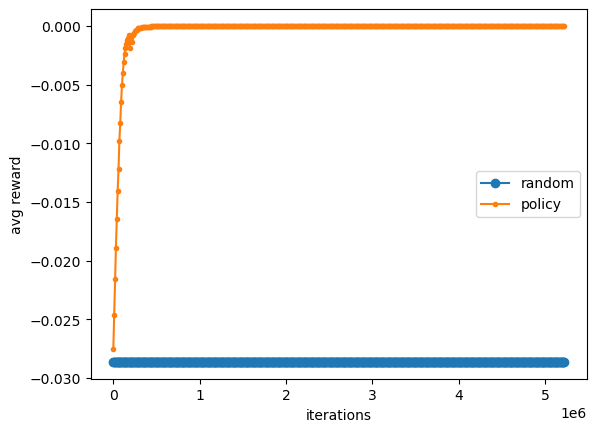

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
CHUNK_SIZE = 100
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])